# Activity Recognition with Healthy Older People Using a Batteryless Wearable Sensor

This notebook provides code for loading the [activity recognition dataset](https://archive.ics.uci.edu/dataset/427/activity+recognition+with+healthy+older+people+using+a+batteryless+wearable+sensor) into a suitable format for classification and sequence labelling. 

The code is divided into three sections:
* Loading the data
* Sequence labelling: processing the data into a suitable format for sequence labelling. 
* Classification: processing the data into a suitable format for use with an IID classifier.

We recommend running all three sections, then using the variables produced by the code as required for sequence labelling and IID classification.


## Loading the Data

Run the following cells to load the data from disk. You will need to run code from the subsequent sections (or your own code) to get the data into a suitable format for classification and sequence labelling.  

In [367]:
import os

data_path = "activity_recognition_dataset/S1_Dataset"

files = os.listdir(data_path)
print(files)

['d1p01M', 'd1p02M', 'd1p03M', 'd1p04M', 'd1p05M', 'd1p06M', 'd1p07M', 'd1p08F', 'd1p09F', 'd1p10F', 'd1p11F', 'd1p12F', 'd1p13F', 'd1p14F', 'd1p15F', 'd1p16F', 'd1p17F', 'd1p18F', 'd1p19F', 'd1p20F', 'd1p21F', 'd1p22F', 'd1p23F', 'd1p24F', 'd1p25F', 'd1p26F', 'd1p27F', 'd1p28F', 'd1p29F', 'd1p30F', 'd1p31F', 'd1p32F', 'd1p33F', 'd1p34F', 'd1p35F', 'd1p36M', 'd1p37M', 'd1p38M', 'd1p39M', 'd1p40M', 'd1p41M', 'd1p42M', 'd1p43M', 'd1p44M', 'd1p45M', 'd1p46M', 'd1p47M', 'd1p48M', 'd1p49F', 'd1p50F', 'd1p51F', 'd1p52F', 'd1p53F', 'd1p54F', 'd1p55F', 'd1p56F', 'd1p57F', 'd1p58F', 'd1p59F', 'd1p60F', 'README.txt']


In [368]:
import pandas as pd  # use pandas to load data from CSV files

combined_data = []

for file in files:
    
    if file == "README.txt":
        continue
    
    try:
        # load a single sequence from the file
        seq_dataframe = pd.read_csv(os.path.join(data_path, file), header=None, names=["time", "frontal acc", "vertical acc", "lateral acc", "antenna ID", "RSSI", "phase", "frequency", "label"])
        
        # put the ID of the sequence into the dataframe as an extra column
        seq_dataframe['seqID'] = file  # use filename as ID
                
        combined_data.append(seq_dataframe)  # put the data frame into a list
    except:
        print(f"Could not load file {file}. Skipping.")

In [369]:
combined_data

[       time  frontal acc  vertical acc  lateral acc  antenna ID  RSSI  \
 0      0.00      0.27203       1.00820    -0.082102           1 -63.5   
 1      0.50      0.27203       1.00820    -0.082102           1 -63.0   
 2      1.50      0.44791       0.91636    -0.013684           1 -63.5   
 3      1.75      0.44791       0.91636    -0.013684           1 -63.0   
 4      2.50      0.34238       0.96229    -0.059296           1 -63.5   
 ..      ...          ...           ...          ...         ...   ...   
 396  251.00      0.87003       0.46851     0.009122           4 -58.5   
 397  251.25      0.87003       0.46851     0.009122           1 -57.5   
 398  251.50      0.87003       0.46851     0.009122           1 -59.0   
 399  253.25     -0.00938       0.95081    -0.116310           1 -58.5   
 400  254.00     -0.00938       0.95081    -0.116310           1 -56.5   
 
        phase  frequency  label   seqID  
 0    2.42520     924.25      1  d1p01M  
 1    4.73690     921.75  

In [370]:
import numpy as np
import matplotlib.pyplot as plt

from hmmlearn import hmm
from IPython import display

import nltk
from nltk.corpus import brown
from nltk.probability import ConditionalFreqDist,ConditionalProbDist,MLEProbDist
import itertools

from sklearn.model_selection import train_test_split


# interactive display
import ipywidgets as widgets
%config InlineBackend.figure_format = 'retina'

## Sequence Labelling

The following cell creates two variables that you can use for sequence labelling:
* X_by_seq is a list of 2-D numpy arrays. Each numpy array in this list corresponds to on data sequence and contains the input feature values for that sequence.
* y_by_seq is a list of 1-D numpy arrays, where each array contains the target class labels for each sequence. 

In [371]:
import numpy as np

# the pandas dataframe stores data in a table with headers
input_cols = ["frontal acc", "vertical acc", "lateral acc", "RSSI", "phase", "frequency"]  # column headers for the input features
output_col = "label"  # column header for the output label

# get the relevant columns from the pandas dataframes and convert to numpy arrays
X_by_seq = []  # store a list of numpy arrays containing the input features for each sequence
y_by_seq = []  # store a list of 1-D numpy arrays containing the target activity labels for each sequence

for seq_table in combined_data:
    X_by_seq.append(seq_table[input_cols].values)
    y_by_seq.append(seq_table[output_col].values - 1)    # subtract one from the label so that labels start from 0
    
n_states = np.unique(np.concatenate(y_by_seq)).size  # how many classes/states are there?

In [372]:
feature_names = input_cols
target_names = np.unique(np.concatenate(y_by_seq)).tolist()

### Variables for sequence labelling

The cell below produces the data you need for sequence labelling... You should be able to work with these variables directly.

In [373]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import graphviz

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\Ram\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['display', 'text']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [374]:
from sklearn.model_selection import train_test_split

# create train/test split. Sequences are kept complete.
X_by_seq_tr, X_by_seq_test, y_by_seq_tr, y_by_seq_test = train_test_split(X_by_seq, y_by_seq, test_size=0.2, random_state=21)  # You may wish to make further splits of the data or to modify this split.

In [375]:
X_by_seq_tr[0][0]

array([ 3.8928e-01,  9.5081e-01,  7.7541e-02, -5.6000e+01,  3.7874e+00,
        9.2225e+02])

You may find the following code useful for creating a sequence labelling model:

In [376]:
# Record which observations occur given each state (activity label)
X_given_y = [[] for _ in range(n_states)]  # empty list where we will record the observations that occur given each activity label

for s, X_seq in enumerate(X_by_seq_tr):
    for i in range(X_seq.shape[0]):
        state_i = y_by_seq_tr[s][i]
        X_given_y[state_i].append(X_seq[i, :][None, :])

In [377]:
from hmmlearn import hmm  # We recommend using this class if builing an HMM

# Record the mean feature values for observations in each state
means = np.zeros((n_states, len(input_cols)))

# Record the variance of feature values for observations in each state
diagonal_covars = np.zeros((n_states, len(input_cols)))

for state in range(n_states):
    means[state] = np.mean(X_given_y[state], axis=0)
    diagonal_covars[state, :] = np.var(X_given_y[state], axis=0)

In [378]:
startprob = (np.bincount([seq[0] for seq in y_by_seq_tr]) / len(y_by_seq_tr))

In [379]:

transmat = np.zeros((4, 4))
for seq_states in y_by_seq_tr:
    for i in range(len(seq_states) - 1):
        transmat[seq_states[i], seq_states[i+1]] += 1

transmat /= np.sum(transmat, axis=1, keepdims=True)
transmat

array([[9.91003677e-01, 0.00000000e+00, 5.00664946e-03, 3.98967379e-03],
       [0.00000000e+00, 9.89473684e-01, 1.00250627e-03, 9.52380952e-03],
       [1.96829260e-03, 0.00000000e+00, 9.97208603e-01, 8.23104176e-04],
       [2.69340974e-02, 2.46418338e-02, 5.73065903e-03, 9.42693410e-01]])

In [395]:
from hmmlearn import hmm

model = hmm.GaussianHMM(n_components=n_states, algorithm='viterbi', covariance_type='diag', random_state=42, init_params='')
model.startprob_ = startprob
model.transmat_ = transmat
model.means_ = means
model.covars_ = diagonal_covars

flat_X_tr = [elem for seq in X_by_seq_tr for elem in seq]
flat_X_test = [elem for seq in X_by_seq_test for elem in seq]
#calculate lengths for both training and test sequences
lengths_train = [len(seq) for seq in X_by_seq_tr]
lengths_test = [len(seq) for seq in X_by_seq_test]

model.fit(flat_X_tr, lengths=lengths_train)

GaussianHMM(init_params='', n_components=4, random_state=42)

In [396]:
hidden_states_test = model.predict(flat_X_test, lengths=lengths_test)

In [398]:
from sklearn.metrics import accuracy_score
true_label_states_test = [state for seq_states in y_by_seq_test for state in seq_states]
accuracy = accuracy_score(true_label_states_test, hidden_states_test)
print(f"Accuracy Score: {accuracy:.4f}")

Accuracy Score: 0.8070


              sit on bed  sit on chair     lying  ambulating
sit on bed      0.976809      0.000000  0.000436    0.022755
sit on chair    0.000000      0.969590  0.008375    0.022035
lying           0.000195      0.000000  0.997279    0.002526
ambulating      0.056282      0.040873  0.008011    0.894835


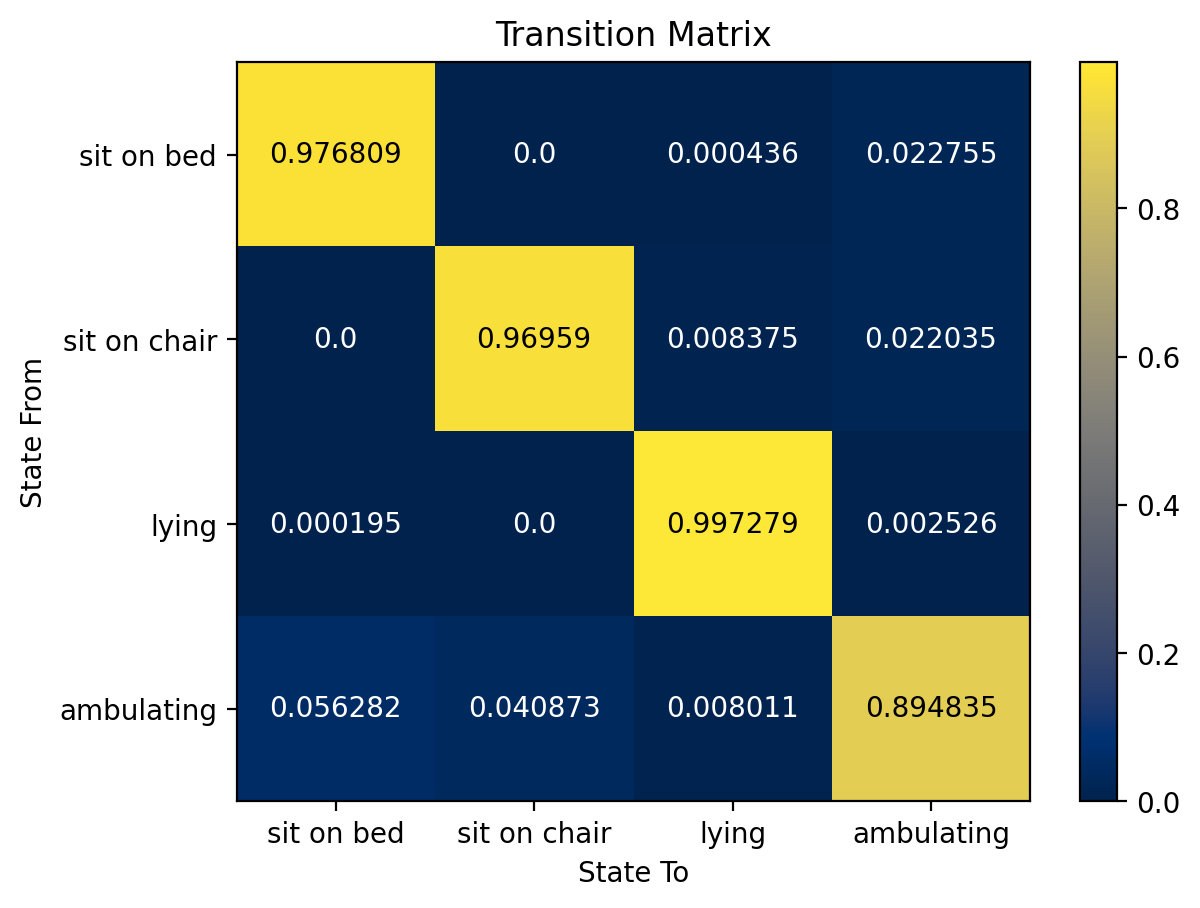

In [383]:
column_labels = ['sit on bed', 'sit on chair', 'lying', 'ambulating']
transmat_with_labels = pd.DataFrame(model.transmat_, columns=column_labels, index=column_labels)
print(transmat_with_labels)

fig, ax = plt.subplots()

for i in range(len(column_labels)):
    for j in range(len(column_labels)):
        if i == j:
            text = ax.text(j, i, round(model.transmat_[i, j], 6),
                           ha="center", va="center", color="black")
        else:
            text = ax.text(j, i, round(model.transmat_[i, j], 6),
                           ha="center", va="center", color="w")

img = ax.imshow(model.transmat_, aspect='auto', cmap='cividis')
ax.set_title('Transition Matrix')
ax.set_xlabel('State To')
ax.set_ylabel('State From')
ax.set_xticks(range(len(column_labels)))
ax.set_yticks(range(len(column_labels)))
ax.set_xticklabels(column_labels)
ax.set_yticklabels(column_labels)
plt.colorbar(img, ax=ax)
plt.show()

In [384]:
import pandas as pd
means = model.means_
feature_names = ["frontal acc", "vertical acc", "lateral acc", "RSSI", "phase", "frequency"]
labels = ['sit on bed', 'sit on chair', 'lying', 'ambulating']
means_df = pd.DataFrame(means, columns=feature_names, index=labels)
print(means_df)

              frontal acc  vertical acc  lateral acc       RSSI     phase  \
sit on bed       0.315452      0.968343     0.039093 -58.413312  3.238497   
sit on chair     0.659959      0.828318     0.082466 -59.173712  3.349652   
lying            1.091676      0.003837    -0.025791 -58.431152  3.320219   
ambulating       0.156979      0.963522     0.059106 -57.035387  3.045852   

               frequency  
sit on bed    922.749516  
sit on chair  922.693184  
lying         922.798317  
ambulating    922.773597  


In [385]:
means_df

,frontal acc,vertical acc,lateral acc,RSSI,phase,frequency
sit on bed,0.315452,0.968343,0.039093,-58.413312,3.238497,922.749516
sit on chair,0.659959,0.828318,0.082466,-59.173712,3.349652,922.693184
lying,1.091676,0.003837,-0.025791,-58.431152,3.320219,922.798317
ambulating,0.156979,0.963522,0.059106,-57.035387,3.045852,922.773597
